In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from tqdm import tqdm

import os
import sys

from scipy.optimize import minimize
# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [2]:
windows = c.windows
number_crypto = c.number_cryptos
market_cap = c.market_cap

df_name_index = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

In [3]:
## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_sorted.csv', index_col=0)


df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]
df_final_data_return = np.log(df_final_data/df_final_data.shift(1)).dropna()


/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [4]:
def Min_variance(alloc, return_cov_matrix):
    matrix_one = np.ones(len(return_cov_matrix))
    criterion = 0.5*np.dot(np.transpose(alloc).dot(return_cov_matrix),alloc)
    return criterion

def optimizer(cov_matrix_test):
    length = len(cov_matrix_test)

    x0 = np.zeros(length) + 0.001

    Bounds= [(0 , 1) for i in range(0,length)] #Long only positions
    cons=({'type':'eq', 'fun': lambda x:sum(x)-1}) #Sum of weights is equal to 1


    #Optimisation
    res_MIN_VAR = minimize(Min_variance, x0, method='SLSQP', args=(cov_matrix_test),bounds=Bounds,constraints=cons,options={'disp': False})
    return res_MIN_VAR.x


length_index = df_final_data_return.shape[0]

weights_min_var = []
for i in tqdm(range(length_index-windows)):
    cov_matrix = df_final_data_return.iloc[i:windows+i].cov()
    weight = optimizer(cov_matrix.values)
    weights_min_var.append(weight)

labels = df_final_data_return.columns

df_results_min_var = pd.DataFrame(weights_min_var)
df_results_min_var.columns = labels
#df_results_min_var.index = df_final_data_return.iloc[windows:].index

  0%|          | 0/1764 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
100%|██████████| 1764/1764 [01:12<00:00, 24.26it/s] 


In [5]:
df_results_min_var.tail(10)

,bitcoin,litecoin,ripple,nxt,dogecoin,digibyte,dash,monero,bitshares,stellar,verge,nem,ethereum,siacoin,decred,lisk,steem,digixdao,bytecoin-bcn,augur
1754,0.221283,0.072837,4.947688e-04,0.231233,0.000000e+00,0.000000e+00,0.049788,0.085161,7.806256e-18,0.042463,9.866240e-18,7.589415e-18,0.089826,0.000000e+00,0.106927,0.000000e+00,3.252607e-18,0.099986,1.734723e-18,1.301043e-18
1755,0.223792,0.070867,1.301043e-18,0.228328,5.421011e-19,0.000000e+00,0.048276,0.087674,0.000000e+00,0.043580,5.746272e-18,6.505213e-19,0.090879,0.000000e+00,0.104984,0.000000e+00,0.000000e+00,0.101620,1.192622e-18,0.000000e+00
1756,0.207625,0.070503,0.000000e+00,0.238873,1.084202e-18,0.000000e+00,0.048454,0.089054,6.656991e-03,0.047113,0.000000e+00,3.469447e-18,0.092733,0.000000e+00,0.096415,0.000000e+00,2.818926e-18,0.102574,0.000000e+00,0.000000e+00
1757,0.212714,0.070127,0.000000e+00,0.244250,9.757820e-19,3.577867e-18,0.046612,0.088271,2.220742e-03,0.042186,0.000000e+00,4.878910e-18,0.090668,4.553649e-18,0.102249,3.577867e-18,3.252607e-18,0.100702,7.589415e-19,7.047314e-18
1758,0.217704,0.070125,0.000000e+00,0.233005,1.734723e-18,4.336809e-18,0.046391,0.090170,0.000000e+00,0.041224,5.416632e-03,0.000000e+00,0.090666,3.469447e-18,0.104054,6.938894e-18,0.000000e+00,0.101086,1.583116e-04,8.673617e-19
1759,0.217407,0.070451,6.938894e-18,0.231898,8.673617e-19,4.336809e-19,0.047257,0.092575,4.865186e-04,0.039994,3.807092e-03,2.602085e-18,0.091064,0.000000e+00,0.103143,0.000000e+00,7.372575e-18,0.101917,0.000000e+00,0.000000e+00
1760,0.217894,0.070556,3.469447e-18,0.233846,4.770490e-18,7.697835e-18,0.047967,0.093331,0.000000e+00,0.036537,3.830590e-03,3.469447e-18,0.090778,2.168404e-18,0.103800,8.239937e-18,5.312591e-18,0.101461,1.084202e-18,0.000000e+00
1761,0.214566,0.070214,4.770490e-18,0.234049,7.155734e-18,6.179952e-18,0.047704,0.095253,1.235990e-17,0.037181,3.469447e-18,6.505213e-19,0.091953,1.734723e-18,0.106434,8.023096e-18,0.000000e+00,0.102645,0.000000e+00,5.312591e-18
1762,0.213371,0.069309,9.974660e-18,0.235117,2.602085e-18,0.000000e+00,0.047221,0.093803,2.125036e-17,0.038376,2.428613e-17,1.084202e-19,0.092071,4.878910e-18,0.107934,2.059984e-18,1.409463e-18,0.102797,0.000000e+00,1.084202e-18
1763,0.204587,0.067860,1.734723e-18,0.251705,0.000000e+00,0.000000e+00,0.045001,0.087209,4.770490e-18,0.038739,5.224345e-03,0.000000e+00,0.089258,9.757820e-19,0.111287,2.168404e-18,2.168404e-18,0.099130,0.000000e+00,3.794708e-19


Text(0.5, 1.0, 'Min Variance')

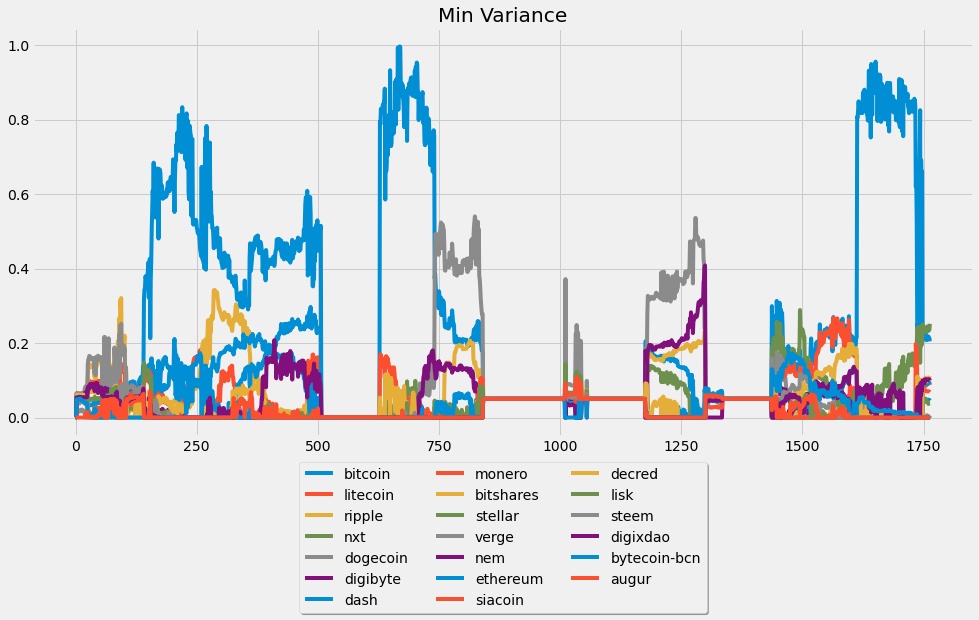

In [6]:
# TODO: mettre une color pour chaque line (http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html)
plt.figure(figsize=(15,7))
plt.plot(df_results_min_var)
plt.legend(df_results_min_var.columns, loc="lower center", fancybox=True, shadow=True,ncol=3,bbox_to_anchor=(0.5, -0.45))
plt.title("Min Variance")

In [7]:
portfolio_min_var = np.sum(np.multiply(df_final_data_return.iloc[windows:], df_results_min_var),1)

<ipython-input-7-428fa6e69948>:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  portfolio_min_var = np.sum(np.multiply(df_final_data_return.iloc[windows:], df_results_min_var),1)


In [8]:
#bug avec ces deux dates
portfolio_min_var = portfolio_min_var.drop(portfolio_min_var[portfolio_min_var.index == pd.to_datetime("2018-05-09") ].index)
portfolio_min_var = portfolio_min_var.drop(portfolio_min_var[portfolio_min_var.index == pd.to_datetime("2018-05-10") ].index)
portfolio_min_var

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


date
2016-12-19   -0.000269
2016-12-20   -0.000190
2016-12-21    0.007384
2016-12-22    0.000919
2016-12-23    0.017997
                ...   
2021-10-13    0.013295
2021-10-14    0.013887
2021-10-15    0.030246
2021-10-16   -0.005268
2021-10-17   -0.001611
Length: 1762, dtype: float64

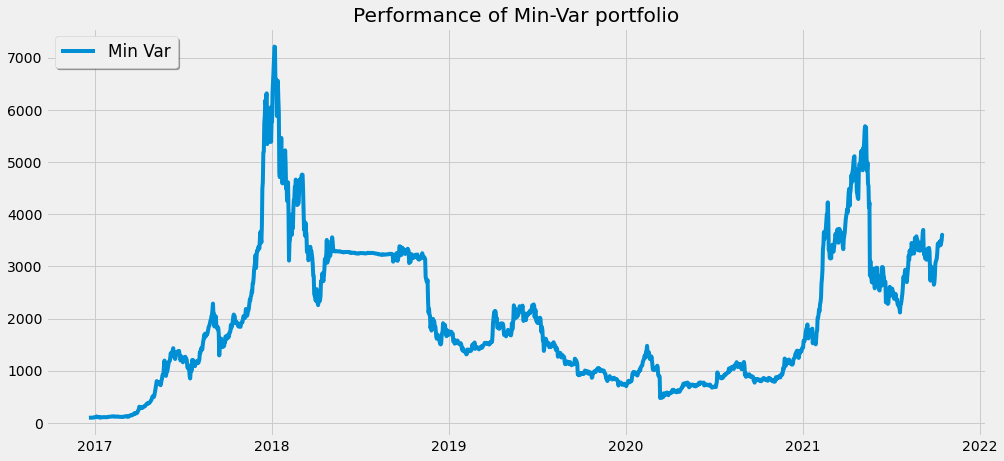

In [9]:
# TODO: debug end of the performance graph
plt.figure(figsize=(15,7))
plt.plot((portfolio_min_var+1).cumprod()*100)
plt.legend(['Min Var'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.title('Performance of Min-Var portfolio')
#plt.show()
MV = (portfolio_min_var+1).cumprod()*100
MV = MV.iloc[2:]
#MV.to_csv(f"../data/processed/MV_{number_crypto}_price.csv")

In [10]:
portfolio_min_var.drop(portfolio_min_var[portfolio_min_var.index < pd.to_datetime("2018-05-06") ].index)

date
2018-05-06   -0.021724
2018-05-07   -0.037593
2018-05-08   -0.016422
2018-05-11   -0.001873
2018-05-12    0.000277
                ...   
2021-10-13    0.013295
2021-10-14    0.013887
2021-10-15    0.030246
2021-10-16   -0.005268
2021-10-17   -0.001611
Length: 1259, dtype: float64